In [1]:
__nbid__ = '0079'
__author__ = 'Brian Merino <brian.merino@noirlab.edu>'
__version__ = '20260121' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['des_dr2', 'skymapper_dr4']
__keywords__ = ['AladinLite', 'globular clusters', 'ipyaladin']

# Displaying images and catalogs with Aladin Lite v3
*Brian Merino (NSF NOIRLab/CSDC)*

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Start Aladin viewer](#Aladin)
* [Accessing the data](#Data)
* [Simple Image Access (SIA) Service Tool](#SIA)
* [Query the des_dr2 imaging data](#des_dr2)
* [Querying the Data Lab database](#Query)
* [Overlay table](#overlay_table)
* [Color Magnitude Diagram](#CMD)

<a class="anchor" id="goals"></a>
# Goals
Demonstrate how to display image and catalog data with the AladinLite Viewer in a notebook (using ipyaladin). The image and catalog data will be obtained through Data Lab's data services.

<a class="anchor" id="summary"></a>
# Summary
<a href="https://aladin.cds.unistra.fr/AladinLite/doc/">AladinLite</a> is an interactive sky atlas that runs in your browser. Aladin allows users to explore the sky and display images. Additionally, it enables the overlay of catalog objects, facilitating object identification. <a href="https://github.com/cds-astro/ipyaladin">ipyaladin</a> was created to allow Jupyter Notebooks to utilize Aladin Lite's functionality. This notebook will demonstrate how to use ipyaladin to display images and overlay survey catalog data, which would help identify overlapping datasets.

Visualizing surveys like this allows users to explore whether a source of interest has already been observed by a survey. By executing a cone search and overlaying the found objects, one can check if sources visible in images have counterparts in specific catalogs, which can be beneficial when preparing a telescope proposal. 


<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
## Disclaimers
Note that using the Astro Data Lab constitutes your agreement with our minimal <a href="https://datalab.noirlab.edu/about/disclaimers">Disclaimers</a>.

## Acknowledgments
If you use Astro Data Lab in your published research, please include the text in your paper's Acknowledgments section:

This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation.

If you use SPARCL jointly with the Astro Data Lab platform (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation.

In either case please cite the following papers:

Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097
If publishing in a AAS journal, also add the keyword: \facility{Astro Data Lab}

And if you are using SPARCL, please also add \software{SPARCL} and cite:

Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024 https://doi.org/10.48550/arXiv.2401.05576
The NOIRLab Library maintains lists of proper acknowledgments to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="imports"></a>
# Imports and setup

In [2]:
# Standard library
from getpass import getpass
import time

# Third-party libraries
import numpy as np
from matplotlib.colors import PowerNorm
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.wcs import WCS
from astropy.table import Table
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.coordinates import SkyCoord
from pyvo.dal import sia
from ipyaladin import Aladin
from sidecar import Sidecar

# Data Lab
from dl import authClient as ac, queryClient as qc  

%matplotlib inline

<a class="anchor" id="Aladin"></a>
# Start Aladin Viewer

Let's start by opening an Aladin Lite viewer using SideCar. Running the following cell will open a new window to the right of where the notebook's cells are shown. 

Note: You do not need to use Sidecar to establish an Aladin Lite viewer session. If you were to just run the first line of the cell block, Aladin Lite would be opened below the code block. You could still interact with the viewer and utilize all of Aladin Lite's tools, but the session would remain below this code block, meaning you would need to scroll back up to this cell everytime you wanted to visit the viewer. 

In [3]:
aladin = Aladin(full_screen=True)
with Sidecar(title="aladin_output",anchor='split-right'):
    display(aladin)

# If you would prefer the Aladin viewer to be displayed somewhere other than the right side,
# feel free to uncomment the following code to display Aladin at the bottom of the screen. 
#with Sidecar(title="aladin_output",anchor='split-bottom'):
#    display(aladin)

# The following line will make the notebook wait three seconds before continuing. 
# This will allow the notebook time to bring up the Aladin Viewer before executing
# the following commands. 
time.sleep(3)

Now that Aladin is running, let's center it on our target, the globular cluster NGC 1851. 

Since the coordinates we are using are in degrees, let's update the coordinate frame Aladin uses.

In [4]:
#Center Aladin on NGC 1851
ra = 78.52809 # in degrees
dec = -40.04656 # in degrees

target_coord = SkyCoord(ra*u.deg,dec*u.deg)
aladin.target = target_coord

#Update the coordinate frame
aladin.coo_frame = "ICRSd"  # ICRS, and angles expressed in degrees

Next, let's adjust the field of view (FOV) so we zoom in on the target. 

In [5]:
aladin.fov = 0.4  # set field of view to 0.4 degrees

After running the previous cell, the Aladin viewer is ready to go. However, feel free to adjust the viewer to your liking. By interacting directly with the viewer, you can click on the '+' or '-' buttons located at the bottom left of the viewer to zoom in or out. Additionally, you can click and drag anywhere on the viewer's screen to adjust the center. You can also change the stretch of the image by right-clicking on the viewer and dragging your mouse around to adjust the brightness. 

<a class="anchor" id="Data"></a>
# Accessing the data

In this notebook, we are going to access two different datasets. First, we will use the Simple Image Access (SIA) service tool to access imaging data from The **D**ark **E**negery **S**urvey [(**DES**)](https://datalab.noirlab.edu/des/index.php), then we will use the query client to access the [**SkyMapper**](https://datalab.noirlab.edu/data/skymapper) fourth data release to identify sources near our target. 

Note: If you want to know where to find the URL used here, check out this [Astro Data Lab user manual page](https://datalab.noirlab.edu/docs/manual/UsingAstroDataLab/DataAccessInterfaces/SimpleImageAccessSIA/SimpleImageAccessSIA.html?highlight=sia) for the list of image collection URLs and other helpful information on using the SIA tool. 

### Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). However, some capacities, such as saving the results of your queries to your virtual storage space, require a login (i.e., you will need a registered user account).

If you need to log in to Data Lab, un-comment the first line of code in the cell below and execute it:

In [6]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'bmerino95'

<a class="anchor" id="SIA"></a>
# SIA service tool

To access the SIA service tool, we need to establish the URL that points to the collection that holds the images we are interested in. For this example, we will access data from the des_dr2 image collection. 

In [7]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2"
svc_des_dr2 = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="des_dr2"></a>
# Query the des_dr2 imaging data

Since we are working with data for the globular cluster NGC 1851 (RA = 78.52809 degrees and Dec = -40.04656 degrees), we will search for corresponding images in the des_dr2 image collection around these coordinates. Since the fov parameter expects values in degrees, we do not need to use a large value.  

In [8]:
fov = 0.2 # in degrees
imgTable_des_dr2 = svc_des_dr2.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
print(f"There are {len(imgTable_des_dr2)} matches. ")

There are 33 matches. 


Preview the table

In [9]:
imgTable_des_dr2

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=1&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=1&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=2&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=2&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=3&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y.fits.fz&extn=3&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y_nobkg.fits.fz&extn=1&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2",image/fits,169453,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0515-3957_r4939p01_Y_nobkg.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y_nobkg.fits.fz&extn=1&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2&preview=true",,,78.9264,-39.9601,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0515-3957,0,DES DR2,30,image,0,0,,585,,Stack,,56615.32558215,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0515-3957_r4939p01_Y_nobkg.fits.fz&extn=2&POS=78.52809,-40.04656&SIZE=0.2612596901922403,0.2",image/fits,169453,,,3,0,0,2,[10000 

Now that we have a table of images, we will select three different bands to see what the cluster looks like in each one. Multiple images are taken with each filter. Here, we will select the first image for each filter as it appears in the table. 

Feel free to change the row used to select the image to see how observations taken with the same filter differ in appearance. 

To access the images, we can use their row numbers from the image table to download them directly into the notebook. 

In [10]:
def download_image(row_val):
    '''Take in a row number from the image table, 
    then return an image, access URL, and its WCS information.
    '''
    row = imgTable_des_dr2[row_val]
    url = row['access_url']
    filename = download_file(url, cache=True, show_progress=False, timeout=120)
    hdu = fits.open(filename)[0]
    image = hdu.data
    hdr = hdu.header
    wcs = WCS(hdr)

    return image, url, wcs

In [11]:
# Image 1 - Y band
image1, url1, wcs1 = download_image(0)

# Image 2 - z band
image2, url2, wcs2 = download_image(27)

# Image 3 - i band
image3, url3, wcs3 = download_image(15)

Let's plot the three downloaded images with matplotlib.

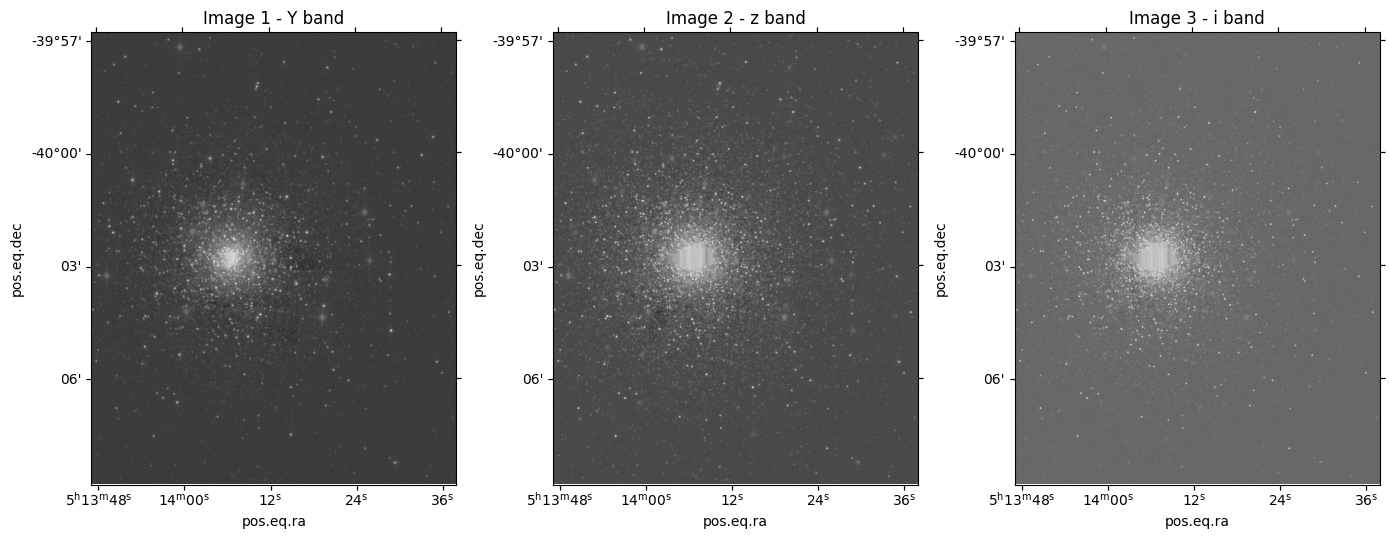

In [12]:
gamma = 0.25
fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(1, 3, 1, projection=wcs1)
im1 = ax1.imshow(image1, origin='lower', cmap='Greys_r', norm=PowerNorm(gamma))
ax1.set_title('Image 1 - Y band')

ax2 = fig.add_subplot(1, 3, 2, projection=wcs2)
im2 = ax2.imshow(image2, origin='lower', cmap='Greys_r', norm=PowerNorm(gamma))
ax2.set_title('Image 2 - z band')

ax3 = fig.add_subplot(1, 3, 3, projection=wcs3)
im3 = ax3.imshow(image3, origin='lower', cmap='Greys_r', norm=PowerNorm(gamma))
ax3.set_title('Image 3 - i band')

plt.tight_layout()
plt.show()

Here we can see how NGC 1851 looks in the Y, z, and i bands. The reddest band, the Y band, shows the older stellar population. The bluer bands, specifically the z and i bands, show more stars, with the z band displaying the most stars. This tells us that the majority of stars in this cluster peak between 850 and 950 nm. 

<a class="anchor" id="overlay_image"></a>
# Overlay images on Aladin

After plotting all three images, we can verify that they are of the same source, but they are not identical. 

Now, we can use the add_fits() function to overlay the images onto Aladin. By default, Aladin sets the opacity of each image to 1.0, which means the sky displayed by the Aladin viewer will not be visible behind the image. If you would like the image to be slightly transparent, you can change the value to be something less than one. For this example, we will set the opacity to 100%, allowing you to see the image clearly. However, feel free to vary the opacity value to see how the image appears against the background. Don't forget to uncomment the add_fits commands for the Y and i bands so you can see what they look like on the sky. 

In [13]:
#Add Y band image to Aladin
#aladin.add_fits(url1,name='Y band',opacity=1.0)

#Add z band image to Aladin
aladin.add_fits(url2,name='z band',opacity=1.0)

#Add i band image to Aladin
#aladin.add_fits(url3,name='i band',opacity=1.0)

After adding the images to Aladin, the viewer will shift slightly, moving our target away from the center of the FOV. You can recenter the FOV by rerunning the aladin.target command that we used earlier in this notebook. 

Note: If you select "Run All Cells" Jupyter does not give Aladin enough time to update the viewer, so this command may be skipped. If this happens to you, return to this cell and execute it again. 

In [14]:
aladin.target = target_coord

<a class="anchor" id="query"></a>
# Query Data Lab

Now that we know how to work with images, let's query Data Lab catalogs to get photometry for individual stars in and around our target. We will use the SkyMapper data release 4. We only need the ra_img, dec_img, and object_id columns for this example. 

According to [Edward W. Olszewski et al. 2009](https://ui.adsabs.harvard.edu/abs/2009AJ....138.1570O/abstract#:~:text=Seitzer%2C%20Patrick-,Abstract,may%20have%20once%20been%20embedded.&text=Keywords:,Astrophysics%20%2D%20Astrophysics%20of%20Galaxies), NGC 1851 has an angular diameter of about 11 arcminutes, which translates to approximately 0.2 degrees. So, we will perform a cone search centered on the globular cluster with a radius of 0.1 degrees. 

The SkyMapper survey contains tens of thousands of data points within our search cone. If we were to overlay the data points as they are, the image would be obscured by a blanket of data markers, completely blocking our view of the globular cluster. To resolve this, we will apply a magnitude cutoff to our query so that only sources with z band magnitudes less than 17 are returned, reducing the number of regions we overlay onto Aladin. 

In [15]:
sql = '''SELECT raj2000, dej2000, z_psf, object_id
            FROM skymapper_dr4.master
            WHERE Q3C_RADIAL_QUERY(raj2000,dej2000,{0},{1},{2}) 
            AND z_psf < 17
'''.format(ra, dec, 0.1)
df = qc.query(sql=sql, fmt='pandas')
df

,raj2000,dej2000,z_psf,object_id
0,78.461009,-40.113166,15.4660,18814683
1,78.461172,-40.098773,16.9116,18814684
2,78.482516,-40.125549,15.2089,18814685
3,78.488081,-40.108811,15.4233,18814690
4,78.484566,-40.106664,15.7141,18814693
...,...,...,...,...
562,78.578968,-39.976615,14.8511,18818053
563,78.585451,-39.975905,16.7421,18818056
564,78.614458,-39.972310,16.4244,18818058
565,78.584157,-39.962496,14.5016,18818060


<a class="anchor" id="overlay_table"></a>
# Overlay Table

Now, we are just about ready to overlay the data from this table on Aladin. But before we can overlay our table, we must first convert it from a 
pandas data frame to a table. 

Finally, we can use Aladin's built-in add_table() function to add the points to our Aladin viewer. 

In [16]:
t = Table.from_pandas(df)

aladin.add_table(
    t,
    shape='circle',
    source_size=15,
    color='green')

The SkyMapper survey was intended to capture objects ranging from magnitude 9 to 22, which explains why the brightest stars at the center of the cluster are not visible in the display. 

<a class="anchor" id="CMD"></a>
# Color Magnitude Diagram

Now that we have visualized the data, let's learn some more about the globular cluster. Using the Skymapper Data Release 4 data, let's build a color-magnitude diagram (CMD). 

Our initial query pulled enough data to visualize the stars near and around the cluster, but there aren't enough data points to produce a good CMD. To fix this, we will repeat our query, but this time, we will set the radius of the cone search equal to the full angular diameter of the cluster, 0.2 degrees. Widening the cone search will increase the number of data points for the CMD, allowing us to identify key characteristics of the diagram. 

The CMD will plot magnitude against color. We will use the i band for the magnitude, but we still need to determine the color, which is defined as the difference between two magnitudes from different filters. This difference in magnitudes serves as a quantitative measurement of the cluster's temperature.

In [17]:
# Repeat the query with a wider cone radius.
# This time, we will also get the g and i band magnitudes.
sql2 = '''SELECT raj2000, dej2000, g_psf, i_psf, object_id
            FROM skymapper_dr4.master
            WHERE Q3C_RADIAL_QUERY(raj2000,dej2000,{0},{1},{2}) 
'''.format(ra, dec, fov/2)
df2 = qc.query(sql=sql2, fmt='pandas')
df2

,raj2000,dej2000,g_psf,i_psf,object_id
0,78.466778,-40.134307,NaN,19.9289,1026338614
1,78.473402,-40.136577,20.7834,NaN,1026338617
2,78.466531,-40.130649,19.1446,18.6132,18814673
3,78.468610,-40.131501,20.7062,NaN,1026338621
4,78.473268,-40.134437,20.2294,19.9081,1026338622
...,...,...,...,...,...
3676,78.589181,-39.965584,20.6010,20.1009,1026348185
3677,78.588390,-39.960792,20.7580,NaN,1026348186
3678,78.588332,-39.958015,18.1991,16.9012,18818061
3679,78.599015,-39.963089,17.9197,17.5492,18818064


Color is defined as the difference in magnitude between two filters. For the CMD we will create here, our color will be the difference between the magnitudes in the g and i bands, color = (g - i) = $m_g - m_i$.

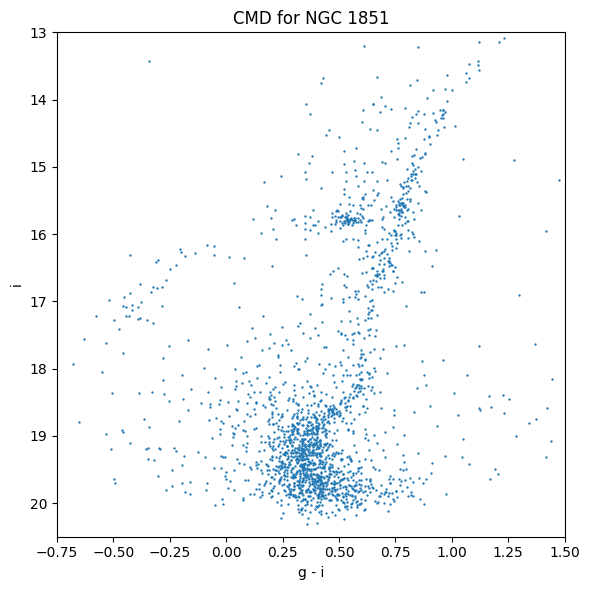

In [18]:
fig = plt.figure(figsize=(6,6))

# Plot color (g-i) vs i
plt.scatter(df2['g_psf']-df2['i_psf'], df2['i_psf'], s=0.5)
plt.xlim(-0.75, 1.5)
plt.ylim(13, 20.5)
plt.gca().invert_yaxis()
plt.xlabel('g - i')
plt.ylabel('i')
plt.title('CMD for NGC 1851')

plt.tight_layout()
plt.show()

This CMD can actually tell us a lot about the cluster if we employ isochrones. An isochrone is a theoretical curve on a CMD that represents stars of the same age and chemical composition but different masses. By overlaying isochrones from stellar evolution models onto our observed CMD, we can estimate properties of the stellar population, such as:

- **Age**
- **Metallicity** ([Fe/H])
- **Distance modulus**
- **Reddening (extinction)**

This process, known as isochrone matching, allows us to interpret the CMD in terms of the physical characteristics of the system rather than just the distribution of points. While isochrone matching is a powerful technique, we will not be covering it in this notebook.